In [1]:
import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image, ImageDraw
import pandas as pd
import scipy.special as sp
import scipy.linalg as sl
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from itertools import islice
import time
%pip install -upgrade ipywidgets
clear_output()
#update

$$ K_{i}^{(t+1)} = K_{i}^{t} + c(K_{\text{max}} - K_{i}^{t}) - x_{i}aK_{i}^{t}$$

utility_:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
utility_:  [5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5.95, 5

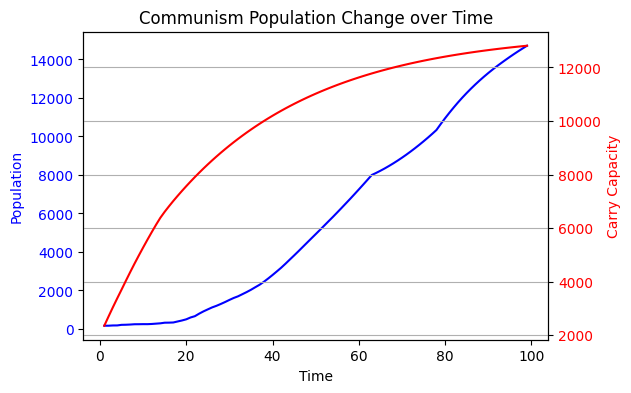

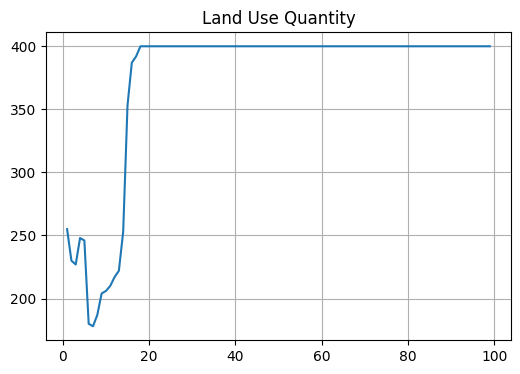

In [2]:
vec1 = pd.read_csv('demog_vectors.csv')

# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land):
    def generate_left_skewed_proportions(num_elements):
        data = skewnorm.rvs(a=-2, loc=0.4, scale=0.2, size=num_elements)
        data = data[data >= 0]
        proportions = data / np.sum(data)
        # Ensure that there are exactly num_elements proportions (padding with zeros if necessary)
        if len(proportions) < num_elements:
            proportions = np.append(proportions, [0] * (num_elements - len(proportions)))
        return proportions

    # Generate age groups and their corresponding proportions to match p0 rows in vec1
    num_p0_rows = vec1.shape[0]
    age_groups = [f'Age Group {i}' for i in range(num_p0_rows)]
    age_proportions = generate_left_skewed_proportions(num_p0_rows)
    age_proportions = np.array(age_proportions) / np.sum(age_proportions)
    
    if len(age_proportions) < num_p0_rows: # make sure age_proportions matches the number of rows in vec1
        age_proportions = np.append(age_proportions, 0)  # add a zero proportion for the extra age group
    
    population_matrix = initial_population * age_proportions
    
    def update_population_matrix(population_matrix, vec1, z):
        p0 = vec1.pstar * sp.gdtr(1.0 / vec1.mortscale[0], vec1.mortparms, z)
        m0 = vec1.mstar * sp.gdtr(1.0 / vec1.fertscale[0], vec1.fertparm[0], z)
        if z > 1.5: m0 *= z
        if z < 1.2: m0 *= z
        N = len(p0)
        m1 = np.zeros([N, N])
        for i in range(N - 1):
            m1[i + 1, i] = p0[i]
        m1[0, :] = m0
        new_population_matrix = np.dot(population_matrix, m1)
        return new_population_matrix

    def calculate_effectiveness_and_consumption(population_matrix, vec1):
        phi = vec1.phi  # Worker effectiveness parameter
        rho = vec1.rho  # Consumption parameter    
        worker_effectiveness = population_matrix * phi
        consumption = population_matrix * rho
        
        return worker_effectiveness, consumption
    
    #updating storage    
    populations = [initial_population]  # store population values over time
    P_values = [[0] for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] for _ in range(simulation_time)] # using land or not decision
    L_values = [initial_capacity for _ in range(initial_lands)] 
    K_values = [] # land carry capacity  
    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): 
                land_assignments[0][i] = { 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }
    
    def find_top_lands(K_t_natural, support_list, consume_list):
        sorted_lands = sorted(enumerate(K_t_natural), key=lambda x: x[1], reverse=True)
        cumulative_utility = 0
        selected_lands = []
        utility_ = []
        for (land_index, utility), support_value in zip(sorted_lands, support_list):
            cumulative_utility += min(utility, support_value) #######
            selected_lands.append(land_index)
            utility_.append(utility)
            if float(cumulative_utility) >= sum(consume_list):  # Update the comparison here ###correct. the non-consistent links 
                break
        if len(selected_lands) > len(support_list):  # Update the comparison here
            selected_lands = selected_lands[:len(support_list)]  # Update the slicing here
        else:
            pass
        print('utility_: ', utility_)
        return selected_lands

    ### Updating process for each year
    for t in range(1, simulation_time): # time 0 is already updated.
        worker_effectiveness, consumption = calculate_effectiveness_and_consumption(population_matrix, vec1)
        flattened_population = population_matrix.flatten()
        flattened_effectiveness = worker_effectiveness.values.flatten()
        flattened_consumption = consumption.values.flatten()
        individual_effectiveness = [(flattened_population[i], flattened_effectiveness[i]) for i in range(len(flattened_population))]
        individual_consumption = [(flattened_population[i], flattened_consumption[i]) for i in range(len(flattened_population))]

        support_list = []
        for item in individual_effectiveness:
            int_part = int(item[0])
            fraction_part = item[0] - int_part
            for i in range(int_part):
                support_list.append((1, item[1]))
            if fraction_part > 0:
                support_list.append((fraction_part, item[1]))
        support_list = [left * right for left, right in support_list]
        support_list.sort(reverse=True)

        consume_list = []
        for item in individual_consumption:
            int_part = int(item[0])
            fraction_part = item[0] - int_part
            for i in range(int_part):
                consume_list.append((1, item[1]))
            if fraction_part > 0:
                consume_list.append((fraction_part, item[1]))
        consume_list = [left * right for left, right in consume_list]
                
        K_t_natural = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.
        K_t = []
        support_counter = 0
        for i in range (initial_lands):
            if support_counter >= len(support_list) -1:
                support = land_assignments[t-1][i]['carry_capacity']  # Reset the counter back to 0 for cycling behavior
            else: support = support_list[support_counter]
            K_t.append(min(support, land_assignments[t-1][i]['carry_capacity']))
            support_counter += 1
        
        selected_lands = find_top_lands(K_t_natural, support_list, consume_list)# select top lands in each year
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): #should I give everyone an agent identity?
                land_assignments[t][i] = {
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }
        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
        P = sum([a * b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).         
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity
    #   updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * K_t_natural[i] * u_t[i])) ############
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)
        z = P / N_t # food availability parameter == carry capacity in my case 
        if z == 0: z = 0.0001
        population_matrix = update_population_matrix(population_matrix, vec1, z) ### didn't update the matrix
        population_matrix[np.isnan(population_matrix)] = 0
        if P  == 0: P = 0.1
        if N_t == 0: N_t = 0.15

        populations.append(np.sum(population_matrix))
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
    populations = populations[1:] # exclude the zero year population 
    return populations, K_values, P_values, u_values, land_assignments

def plot_commuism_simulation_population2(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land):
    
    populations, K, _, U, _ = communism_simulation_population_original(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land)
    
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid(True)
    plt.title('Communism Population Change over Time')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(time_steps, [sum(i) for i in U][:-1])
    plt.grid(True)
    plt.title('Land Use Quantity')
    plt.show()

k = 0.01 # land recovery rate
a = 0.02 # soil loss rate
simulation_time = 100 #simulation year
initial_population = 200
initial_capacity = 5
initial_lands = 400
max_capacity_one_land = 100
plot_commuism_simulation_population2(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land)